<a href="https://colab.research.google.com/github/plerte/coursework1/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
seq_len = 128

Tensorflow version: 2.4.1


         Date      Open      High       Low     Close    Volume
0  1962-01-03  7.626667  7.693333  7.626667  7.693333  292500.0
1  1962-01-04  7.693333  7.693333  7.613333  7.616667  262500.0
2  1962-01-05  7.606667  7.606667  7.453333  7.466667  367500.0
3  1962-01-08  7.460000  7.460000  7.266667  7.326667  547500.0
4  1962-01-09  7.360000  7.506667  7.360000  7.413333  495000.0


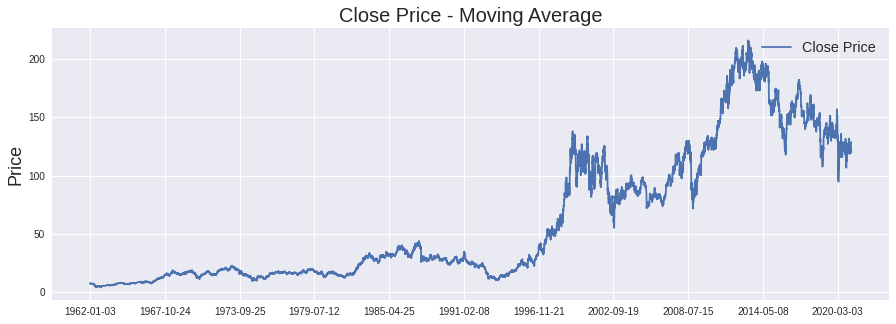

In [ ]:
IBM_path = '/content/drive/MyDrive/coursework/shares_IBM.csv'
df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
date = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
date.dropna(how='any', axis=0, inplace=True) 

print(df.head())
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price - Moving Average", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

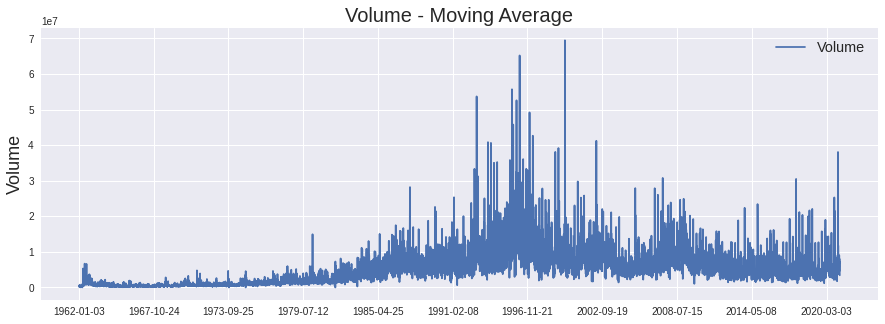

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Volume'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Volume', fontsize=18)
plt.title("Volume - Moving Average", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

In [ ]:
###############################################################################
'''Normalize price columns'''

df['Open'] = (df['Open']-np.mean(df['Open']))/np.std(df['Open'])
df['High'] = (df['High']-np.mean(df['High']))/np.std(df['High'])
df['Low'] = (df['Low']-np.mean(df['Low']))/np.std(df['Low']) 
df['Close'] = (df['Close']-np.mean(df['Close']))/np.std(df['Close'])
df['Volume'] = (df['Volume']-np.mean(df['Volume']))/np.std(df['Volume'])

df.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-03,-0.931955,-0.933106,-0.929603,-0.930713,-1.024398
1,1962-01-04,-0.930794,-0.933106,-0.929837,-0.932049,-1.031103
2,1962-01-05,-0.932304,-0.934603,-0.932646,-0.934661,-1.007634
3,1962-01-08,-0.934859,-0.937138,-0.935922,-0.937099,-0.967402
4,1962-01-09,-0.936601,-0.936331,-0.934284,-0.935589,-0.979136


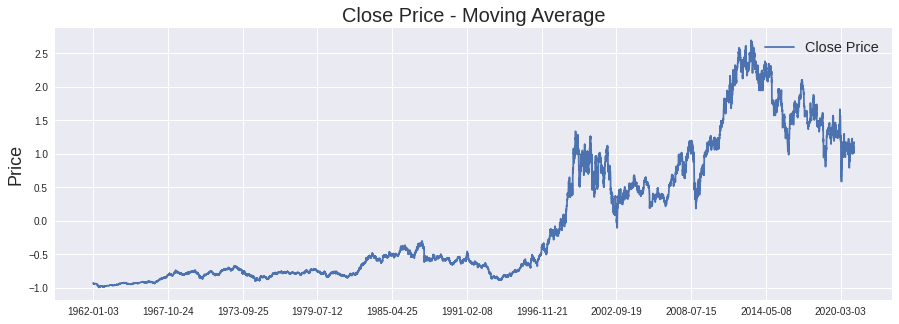

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price - Moving Average", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

In [ ]:
times = df.index.values
last_10pct = df.index.values[-int(0.1*len(times))] # Last 10% of series
last_20pct = df.index.values[-int(0.2*len(times))] # Last 20% of series
print(df.head())


         Date      Open      High       Low     Close    Volume
0  1962-01-03 -0.931955 -0.933106 -0.929603 -0.930713 -1.024398
1  1962-01-04 -0.930794 -0.933106 -0.929837 -0.932049 -1.031103
2  1962-01-05 -0.932304 -0.934603 -0.932646 -0.934661 -1.007634
3  1962-01-08 -0.934859 -0.937138 -0.935922 -0.937099 -0.967402
4  1962-01-09 -0.936601 -0.936331 -0.934284 -0.935589 -0.979136


In [ ]:
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

date_train = date[(date.index < last_20pct)]  # Training data are 80% of total data
date_val = date[(date.index >= last_20pct) & (date.index < last_10pct)]
date_test = date[(date.index >= last_10pct)]
# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print(df.shape)
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))



(14901, 6)
Training data shape: (11921, 5)
Validation data shape: (1490, 5)
Test data shape: (1490, 5)


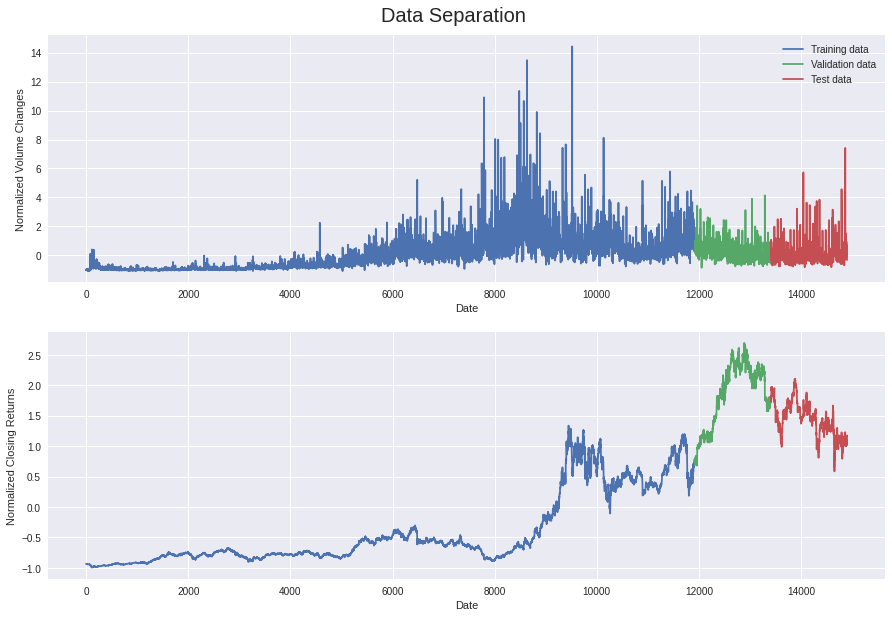

In [ ]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(212)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(211)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

In [ ]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(11793, 128, 5) (11793,)
(1362, 128, 5) (1362,)


In [ ]:
def create_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(64, input_shape=(seq_len, 5), return_sequences=True))
  model.add(tf.keras.layers.LSTM(64,return_sequences=True))
  model.add(tf.keras.layers.LSTM(32))
  model.add(tf.keras.layers.Dense(1))
  model.compile(optimizer="adam", loss="mean_squared_error")
  return model

In [ ]:
model = create_model()

model.summary()

model.fit(X_train, y_train,
              batch_size=1024,
              epochs=30,
              validation_data=(X_val, y_val),)    

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 64)           17920     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128, 64)           33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 63,393
Trainable params: 63,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 133ms/step - loss: 0.2119 - val_loss: 0.6737
Epoch 2/30
12/12 [==============================] - 1s 49ms/step - loss: 0.0193 - val_loss: 0.6128
Epoch 3/30
12/12 [==============================]

In [ ]:
print(model)

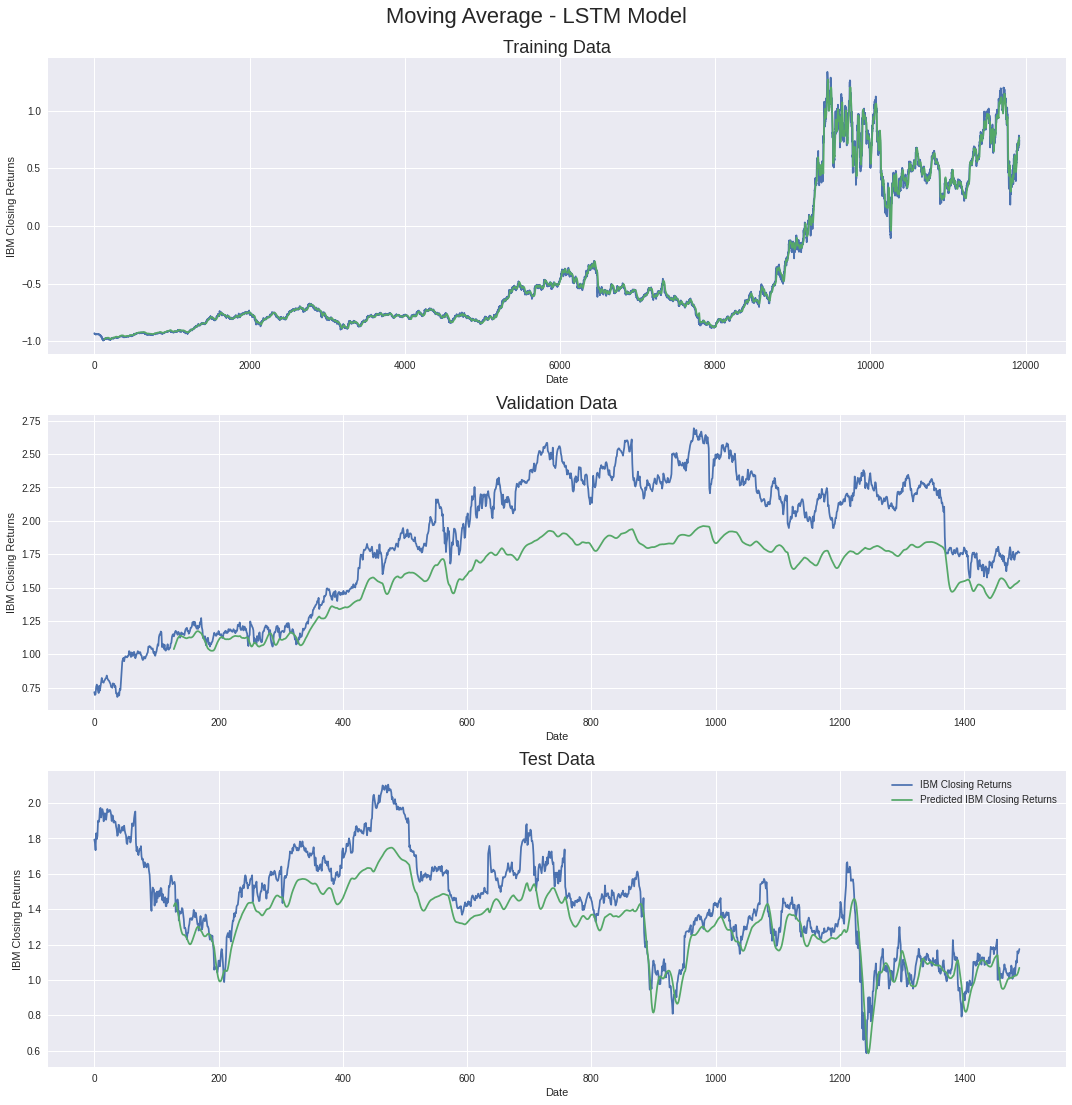

In [ ]:
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len),train_pred, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len),val_pred, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

In [ ]:
IBM_path = '/content/drive/MyDrive/coursework/test_IBM.csv'
exp = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
gr =  pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
exp.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''
mean_close = np.mean(exp['Close'])
std_close = np.std(exp['Close'])
exp['Open'] = (exp['Open']-np.mean(exp['Open']))/np.std(exp['Open'])
exp['High'] = (exp['High']-np.mean(exp['High']))/np.std(exp['High'])
exp['Low'] = (exp['Low']-np.mean(exp['Low']))/np.std(exp['Low'])
exp['Close'] = (exp['Close']-np.mean(exp['Close']))/np.std(exp['Close'])
exp['Volume'] = (exp['Volume']-np.mean(exp['Volume']))/np.std(exp['Volume'])
print(exp)
exp.drop(columns=['Date'], inplace=True)
exp_test2 = exp 

# Convert pandas columns into arrays
exp_test2 = exp_test2.values
print(exp_test2.shape)
X_test2, y_test2 = [], []
for i in range(seq_len, len(exp_test2)):
    X_test2.append(exp_test2[i-seq_len:i])
    y_test2.append(exp_test2[:, 3][i]) 
X_test2, y_test2 = np.array(X_test2), np.array(y_test2)
print(X_test2.shape)


           Date      Open      High       Low     Close    Volume
0    2020-04-13 -0.329835 -0.548416 -0.787635 -0.416913 -0.106451
1    2020-04-14  0.035938  0.133310  0.112074  0.129884 -0.115677
2    2020-04-15 -0.831521 -0.873144 -1.039081 -0.904276  0.047586
3    2020-04-16 -0.853507 -0.961890 -1.498758 -1.490696  0.291706
4    2020-04-17 -0.795543 -0.832806 -0.811208 -0.620971 -0.152192
..          ...       ...       ...       ...       ...       ...
247  2021-04-06  2.458428  2.243034  2.365273  2.172447 -0.552463
248  2021-04-07  2.110643  2.101849  2.304376  2.313107 -0.744414
249  2021-04-08  2.256555  2.241018  2.379025  2.350749 -0.413722
250  2021-04-09  2.316515  2.263205  2.487070  2.471600 -0.730278
251  2021-04-12  2.346498  2.188576  2.318129  2.245749 -0.513061

[252 rows x 6 columns]
(252, 5)
(124, 128, 5)


In [ ]:
o2 = model.predict(X_test2)*(std_close)+mean_close
print(o2.shape)

(124, 1)


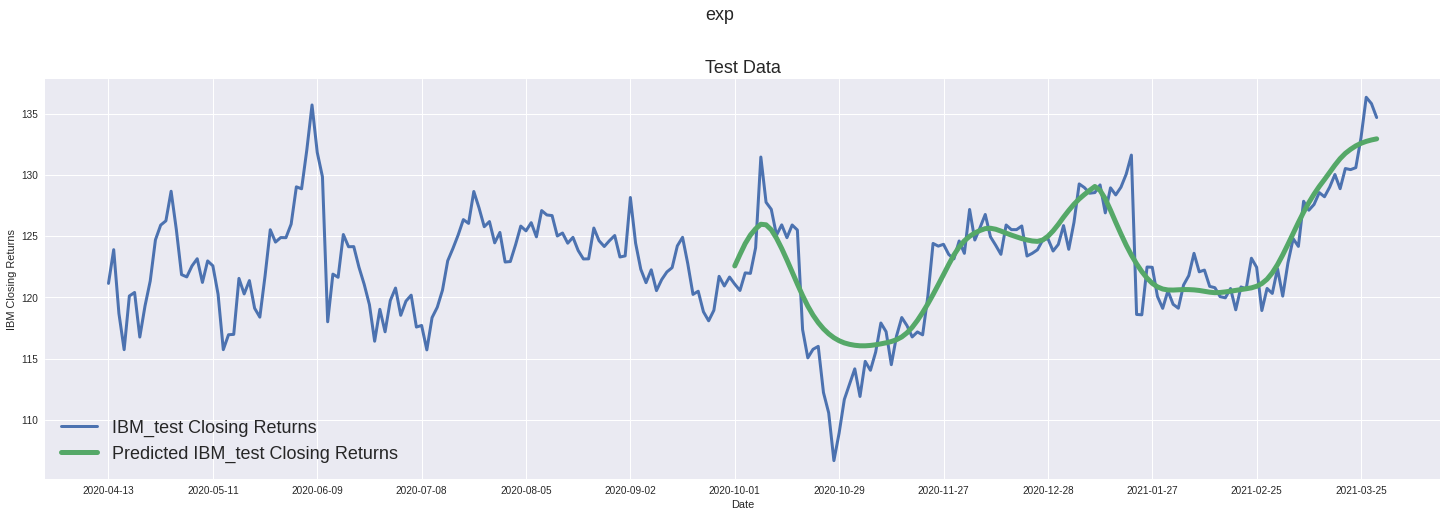

In [ ]:
fig = plt.figure(figsize=(25,25))
st = fig.suptitle("exp", fontsize=18)
st.set_y(0.92)
ax41 = fig.add_subplot(311)
ax41.plot(gr['Date'].loc[0:243],gr['Close'].loc[0:243], linewidth=3, label='IBM_test Closing Returns')
ax41.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax41.plot(np.arange((seq_len-8),o2.shape[0]+seq_len-8) ,o2,linewidth=5,  label='Predicted IBM_test Closing Returns')
ax41.set_title("Test Data", fontsize=18)
ax41.set_xlabel('Date')
ax41.set_ylabel('IBM Closing Returns')
ax41.legend(loc="best", fontsize=18)

In [ ]:
pr = o2
sum=100000
nsum = sum
op = gr["Close"].loc[seq_len-8]
cl = gr["Close"].loc[seq_len-8]
print(gr["Date"].loc[seq_len-8], " - ",gr["Date"].loc[251])
print("Начальная сумма в долларах:", sum)
k=sum/gr["Open"].loc[0]
for i in range (1,len(pr)-1):
  if (pr[i]>pr[i-1] and pr[i]>pr[i+1]):
    sum = k*gr["Close"].loc[i+seq_len-8]
    k = sum/gr["Close"].loc[i+seq_len-8]
    cl = gr["Close"].loc[i+seq_len-8]
    print("max", gr["Date"].loc[i+seq_len], " Сумма в этот день: ", '%.3f' % sum,)
  elif (pr[i]<pr[i-1] and pr[i]<pr[i+1]):
    op = gr["Close"].loc[i+seq_len-8]
    sum = sum + k*(cl-op)
    k = sum/op
    print("min",gr["Date"].loc[i+seq_len-8], " Сумма в этот день: ",'%.3f' % sum)
  
print("Итоговая сумма", sum)
print("Заработано за 252 дня ",'%.3f' %  float(sum-nsum), "или же начальная сумма увеличилась в ", '%.3f' % float(sum/nsum), "раз" )

2020-10-01  -  2021-04-12
Начальная сумма в долларах: 100000
max 2020-10-20  Сумма в этот день:  108106.559
min 2020-11-05  Сумма в этот день:  121853.175
max 2020-12-22  Сумма в этот день:  132672.066
min 2020-12-23  Сумма в этот день:  133797.482
max 2021-01-22  Сумма в этот день:  138851.334
min 2021-02-02  Сумма в этот день:  148721.462
max 2021-02-17  Сумма в этот день:  150688.803
min 2021-02-12  Сумма в этот день:  150962.730
Итоговая сумма 150962.72999446024
Заработано за 252 дня  50962.730 или же начальная сумма увеличилась в  1.510 раз


In [ ]:
NVDA_path = '/content/drive/MyDrive/coursework/NVDA.csv'
exp1 = pd.read_csv(NVDA_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
last_10pct = exp1.index.values[-int(0.1*len(exp1))] 
exp =  exp1[(exp1.index >= last_10pct)]
gr = exp1[(exp1.index >= last_10pct)]
# Replace 0 to avoid dividing by 0 later on
exp['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
exp.sort_values('Date', inplace=True)
exp.tail()

exp.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values


###############################################################################
'''Normalize price columns'''
mean_close = np.mean(exp['Close'])
std_close = np.std(exp['Close'])
exp['Open'] = (exp['Open']-np.mean(exp['Open']))/np.std(exp['Open'])
exp['High'] = (exp['High']-np.mean(exp['High']))/np.std(exp['High'])
exp['Low'] = (exp['Low']-np.mean(exp['Low']))/np.std(exp['Low'])
exp['Close'] = (exp['Close']-np.mean(exp['Close']))/np.std(exp['Close'])
exp['Volume'] = (exp['Volume']-np.mean(exp['Volume']))/np.std(exp['Volume'])

exp.drop(columns=['Date'], inplace=True)
exp_test2 = exp 

exp_test2 = exp_test2.values
X_test2, y_test2 = [], []
for i in range(seq_len, len(exp_test2)):
    X_test2.append(exp_test2[i-seq_len:i])
    y_test2.append(exp_test2[:, 3][i]) 
X_test2, y_test2 = np.array(X_test2), np.array(y_test2)

print(X_test2.shape)

(280, 128, 5)


In [ ]:
test_pred2 = model.predict(X_test2)
# print(model.predict(X_test2))
o2 = model.predict(X_test2)*(std_close)+mean_close
# print(o2)
print(test_pred2.shape)
print(test_pred2[0][0],' ',y_test2[0])

(280, 1)
-0.7165408   -0.7897212872818624


280


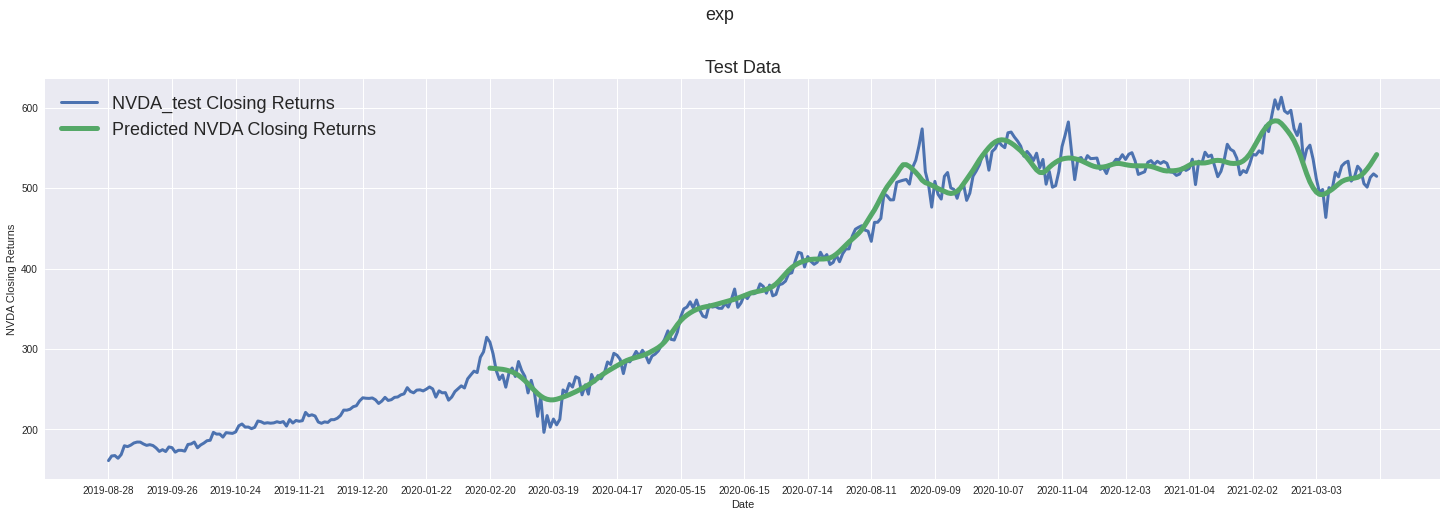

In [ ]:
fig = plt.figure(figsize=(25,25))
# print(len(test_pred2))
print(len(y_test2))
st = fig.suptitle("exp", fontsize=18)
st.set_y(0.92)
ax41 = fig.add_subplot(311)
ax41.plot(gr['Date'].loc[3679:4079],gr['Close'].loc[3679:4079], linewidth=3, label='NVDA_test Closing Returns')
ax41.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax41.plot(np.arange((seq_len-8),o2.shape[0]+seq_len-8) ,o2,linewidth=5,  label='Predicted NVDA Closing Returns')
ax41.set_title("Test Data", fontsize=18)
ax41.set_xlabel('Date')
ax41.set_ylabel('NVDA Closing Returns')
ax41.legend(loc="best", fontsize=18)

In [ ]:
pr = o2
sum=100000
nsum = sum
sdvig =  3679
cl = gr["Close"].loc[sdvig +seq_len-8]
op = gr["Close"].loc[sdvig +seq_len-8]
print(gr["Date"].loc[sdvig + seq_len-8], " - ",gr["Date"].loc[sdvig+408])
print("Начальная сумма в долларах:", sum)
k=sum/gr["Open"].loc[sdvig+1]
for i in range (1,len(pr)-1):
  if (pr[i]>pr[i-1] and pr[i]>pr[i+1]):
    sum = k*gr["Close"].loc[sdvig +i+seq_len-8]
    k = sum/gr["Close"].loc[sdvig +i+seq_len-8]
    cl = gr["Close"].loc[sdvig +i+seq_len-8]
    print("max", gr["Date"].loc[sdvig +i+seq_len], " Сумма в этот день: ", '%.3f' % sum,)
  elif (pr[i]<pr[i-1] and pr[i]<pr[i+1]):
    op = gr["Close"].loc[sdvig +i+seq_len-8]
    sum = sum + k*(cl-op)
    k = sum/op
    print("min",gr["Date"].loc[sdvig +i+seq_len-8], " Сумма в этот день: ",'%.3f' % sum)
  
print("Итоговая сумма", sum)
print("Заработано за 408 дней ",'%.3f' %  float(sum-nsum), "или же начальная сумма увеличилась в ", '%.3f' % float(sum/nsum), "раз" )

2020-02-19  -  2021-04-12
Начальная сумма в долларах: 100000
min 2020-03-17  Сумма в этот день:  160673.812
max 2020-09-04  Сумма в этот день:  377151.206
min 2020-09-15  Сумма в этот день:  370022.297
max 2020-10-19  Сумма в этот день:  397736.217
min 2020-10-26  Сумма в этот день:  421170.563
max 2020-11-17  Сумма в этот день:  453820.995
min 2020-11-19  Сумма в этот день:  476888.657
max 2020-12-10  Сумма в этот день:  475513.736
min 2020-12-08  Сумма в этот день:  477341.064
max 2020-12-22  Сумма в этот день:  463834.292
min 2020-12-21  Сумма в этот день:  450962.206
max 2021-01-19  Сумма в этот день:  426684.381
min 2021-01-07  Сумма в этот день:  402009.086
max 2021-01-27  Сумма в этот день:  397678.390
min 2021-01-22  Сумма в этот день:  382246.057
max 2021-02-23  Сумма в этот день:  411564.370
min 2021-03-04  Сумма в этот день:  478298.893
Итоговая сумма 478298.89273884345
Заработано за 408 дней  378298.893 или же начальная сумма увеличилась в  4.783 раз


In [ ]:
MCD_path = '/content/drive/MyDrive/coursework/MCD.csv'
exp = pd.read_csv(MCD_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
gr =  pd.read_csv(MCD_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
# Replace 0 to avoid dividing by 0 later on
exp['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
exp.sort_values('Date', inplace=True)
exp.tail()

exp.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values


###############################################################################
'''Normalize price columns'''
mean_close = np.mean(exp['Close'])
std_close = np.std(exp['Close'])
exp['Open'] = (exp['Open']-np.mean(exp['Open']))/np.std(exp['Open'])
exp['High'] = (exp['High']-np.mean(exp['High']))/np.std(exp['High'])
exp['Low'] = (exp['Low']-np.mean(exp['Low']))/np.std(exp['Low'])
exp['Close'] = (exp['Close']-np.mean(exp['Close']))/np.std(exp['Close'])
exp['Volume'] = (exp['Volume']-np.mean(exp['Volume']))/np.std(exp['Volume'])

exp.drop(columns=['Date'], inplace=True)
exp_test2 = exp 

# Convert pandas columns into arrays
exp_test2 = exp_test2.values
print(exp_test2.shape)
X_test2, y_test2 = [], []
for i in range(seq_len, len(exp_test2)):
    X_test2.append(exp_test2[i-seq_len:i])
    y_test2.append(exp_test2[:, 3][i]) 
X_test2, y_test2 = np.array(X_test2), np.array(y_test2)

print(X_test2.shape)

(252, 5)
(124, 128, 5)


In [ ]:
test_pred2 = model.predict(X_test2)
# print(model.predict(X_test2))
o2 = model.predict(X_test2)*(std_close)+mean_close
# print(o2)
print(test_pred2.shape)
print(test_pred2[0][0],' ',y_test2[0])

(124, 1)
0.2066254   0.2972109583823201


124


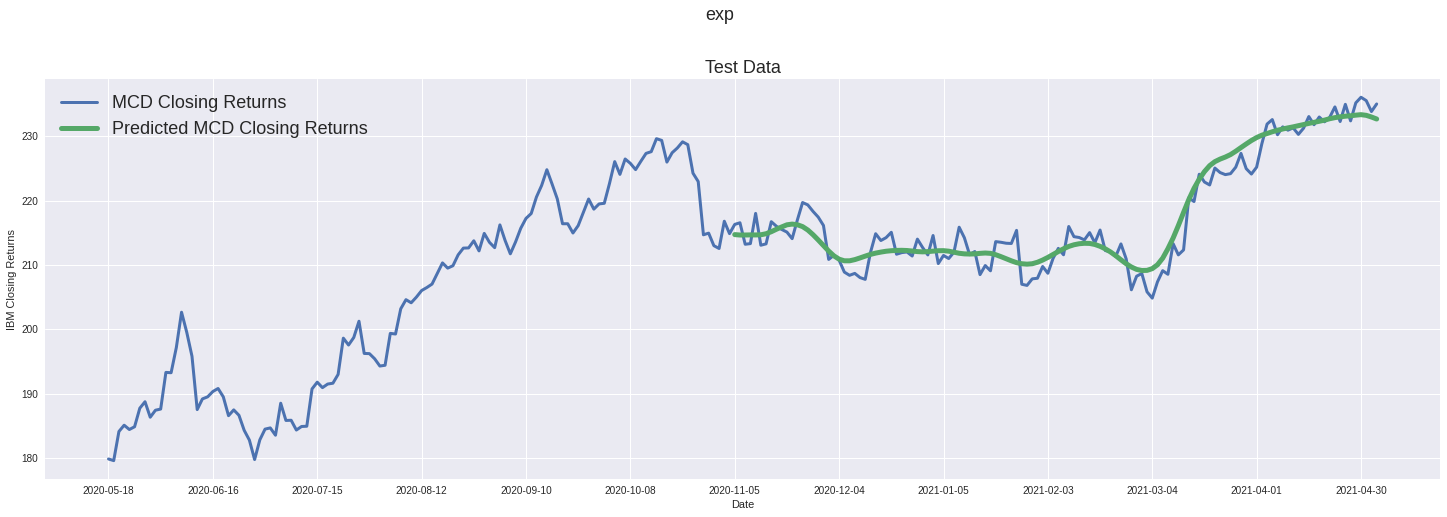

In [ ]:
fig = plt.figure(figsize=(25,25))
# print(len(test_pred2))
print(len(y_test2))
st = fig.suptitle("exp", fontsize=18)
st.set_y(0.92)
ax41 = fig.add_subplot(311)
ax41.plot(gr['Date'].loc[0:243],gr['Close'].loc[0:243], linewidth=3, label='MCD Closing Returns')
ax41.xaxis.set_major_locator(ticker.MultipleLocator(20))
# np.arange(seq_len, test_pred2.shape[0]+seq_len),
ax41.plot(np.arange((seq_len-8),o2.shape[0]+seq_len-8) ,o2,linewidth=5,  label='Predicted MCD Closing Returns')
ax41.set_title("Test Data", fontsize=18)
ax41.set_xlabel('Date')
ax41.set_ylabel('IBM Closing Returns')
ax41.legend(loc="best", fontsize=18)

In [ ]:
pr = o2
sum=100000
nsum = sum
print(gr["Date"].loc[seq_len-8], " - ",gr["Date"].loc[251])
print("Начальная сумма в долларах:", sum)
k=sum/gr["Open"].loc[seq_len-8]
op = gr["Close"].loc[seq_len-8]
cl = gr["Close"].loc[seq_len-8]

for i in range (1,len(pr)-1):
  if (pr[i]>pr[i-1] and pr[i]>pr[i+1]):
    sum = k*gr["Close"].loc[i+seq_len-8]
    k = sum/gr["Close"].loc[i+seq_len-8]
    cl = gr["Close"].loc[i+seq_len-8]
    print("max", gr["Date"].loc[i+seq_len], " Сумма в этот день: ", '%.3f' % sum,)
  elif (pr[i]<pr[i-1] and pr[i]<pr[i+1]):
    op = gr["Close"].loc[i+seq_len-8]
    sum = sum + k*(cl-op)
    k = sum/op
    print("min",gr["Date"].loc[i+seq_len-8], " Сумма в этот день: ",'%.3f' % sum)
  
print("Итоговая сумма", sum)
print("Заработано за 252 дня ",'%.3f' %  float(sum-nsum), "или же начальная сумма увеличилась в ", '%.3f' % float(sum/nsum), "раз" )

2020-11-05  -  2021-05-17
Начальная сумма в долларах: 100000
min 2020-11-06  Сумма в этот день:  99884.297
max 2020-11-20  Сумма в этот день:  98389.911
min 2020-11-11  Сумма в этот день:  96222.124
max 2020-12-03  Сумма в этот день:  94487.633
min 2020-12-08  Сумма в этот день:  97003.301
max 2021-01-05  Сумма в этот день:  98646.477
min 2020-12-29  Сумма в этот день:  98278.736
max 2021-01-15  Сумма в этот день:  97710.432
min 2021-01-12  Сумма в этот день:  97654.984
max 2021-01-28  Сумма в этот день:  96875.036
min 2021-01-28  Сумма в этот день:  98301.092
max 2021-02-25  Сумма в этот день:  101666.194
min 2021-03-02  Сумма в этот день:  104152.000
max 2021-05-12  Сумма в этот день:  117832.964
Итоговая сумма 117832.96394135713
Заработано за 252 дня  17832.964 или же начальная сумма увеличилась в  1.178 раз
